In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
from torchdyn.datasets import *
from numpy.linalg import norm 

2023-09-25 22:08:28.828052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 22:08:33.028795: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-25 22:08:33.029763: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-09-25 22:08:33.029770: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
import math

def eight_normal_sample(n, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)
    data = []
    for i in range(n):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data

def normal_sample(n, dim):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), torch.eye(dim)
    )
    return m.sample_n(n)

class MLP(torch.nn.Module):
    def __init__(self, dim, w=512, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(w, w),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(w, w),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(w, w),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(w, dim),
        )

    def forward(self, x):
        return self.net(x)


In [3]:
import torchdyn
from torchdyn.core import NeuralODE

class CNF(torch.nn.Module):
    def __init__(self, net, trace_estimator=None, noise_dist=None):
        super().__init__()
        self.net = net
        self.trace_estimator = trace_estimator if trace_estimator is not None else autograd_trace
        self.noise_dist, self.noise = noise_dist, None

    def forward(self, t, x):
        with torch.set_grad_enabled(True):
            x_in = x[:, 1:].requires_grad_(
                True
            )  # first dimension reserved to divergence propagation
            # the neural network will handle the data-dynamics here
            x_out = self.net(torch.cat([x_in, t * torch.ones(x.shape[0], 1)], dim=-1))
            trJ = self.trace_estimator(x_out, x_in, noise=self.noise)
        return (
            torch.cat([-trJ[:, None], x_out], 1) + 0 * x
        )  # `+ 0*x` has the only purpose of connecting x[:, 0] to autograd graph

    def backward(self, t, x):
        with torch.set_grad_enabled(True):
            x_in = x[:, 1:].requires_grad_(
                True
            )  # first dimension reserved to divergence propagation
            # the neural network will handle the data-dynamics here
            x_out = -self.net(torch.cat([x_in, t * torch.ones(x.shape[0], 1)], dim=-1))
            trJ = self.trace_estimator(x_out, x_in, noise=self.noise)
        return (
            torch.cat([-trJ[:, None], x_out], 1) + 0 * x
        )  # `+ 0*x` has the only purpose of connecting x[:, 0] to autograd graph

In [4]:
import time

# First loss
sigma_min = 0.05
dim = 2
model = MLP(dim=dim, time_varying=True)

batch_size = 256
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(1000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1)
    x0, _ = generate_moons(batch_size, noise=0.2)
    x0 = x0 * 3 - 1
    x1 = eight_normal_sample(batch_size, dim, scale=5, var=0.1).float()

    # sample some random times
    a, b = pot.unif(x0.size()[0]), pot.unif(x1.size()[0])
    M = torch.cdist(x0, x1) ** 2
    M = M / M.max()
    # pi = pot.sinkhorn(a, b, M.detach().cpu().numpy(), reg=0.01)
    pi = pot.unbalanced.sinkhorn_knopp_unbalanced(a, b, M.detach().cpu().numpy(), 0.01, reg_m=10)
    # Sample random interpolations on pi
    p = pi.flatten()
    p = p / p.sum()
    choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
    i, j = np.divmod(choices, pi.shape[1])
    
    mu_t = x0[i] * (1 - t) + x1[j] * t
    sigma_t = sigma_min
    x = mu_t + sigma_t * normal_sample(batch_size, dim).float()
    ut = x1[j] - x0[i]
    vt = model(torch.cat([x, t], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if k % 100 == 0:
        end = time.time()
        print(f"{k}: loss {loss.item():0.3f} time {(end - start) / 100:0.2f}")
        start = end
        continue

/home/mila/y/yanlei.zhang/.conda/envs/otenv/lib/python3.10/site-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


0: loss 4.182 time 0.01
100: loss 0.720 time 0.50
200: loss 0.626 time 0.66
300: loss 0.740 time 0.66
400: loss 0.598 time 0.66
500: loss 0.590 time 0.95
600: loss 0.505 time 0.32
700: loss 0.616 time 0.32
800: loss 0.486 time 0.32
900: loss 0.561 time 0.32


In [5]:
torch.save(model, "fm_model_v8_big_moon_ot.pt")

In [6]:
model = torch.load("fm_model_v8_big_moon_ot.pt")

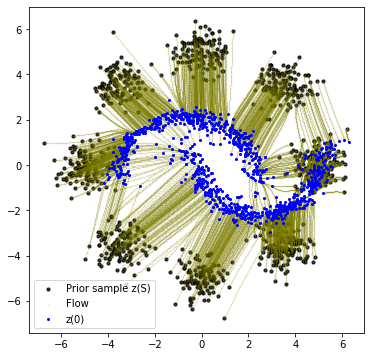

In [7]:
class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x):
        return model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))


node = NeuralODE(
    torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-1, rtol=1e-1
)
dim = 2
full_traj = (
    node.trajectory(
        eight_normal_sample(1 << 10, dim, scale=5, var=0.1).float(),
        t_span=torch.linspace(1, 0, 100),
    )
    .detach()
    .cpu()
)
full_traj.shape
traj = full_traj
n = 2000
plt.figure(figsize=(6, 6))
plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
plt.show()